In [2]:
import os
import sys
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import powerlaw as pl
from scipy import stats
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
import statsmodels.api as sm
from statsmodels.graphics import tsaplots
# add parent directory
sys.path.append('..\\..')
from src.utils import *

In [3]:
# show current databases in data folder
cwd = os.getcwd()
analysis_path = os.path.abspath(os.path.join(cwd, os.pardir))
parent_path = os.path.abspath(os.path.join(analysis_path, os.pardir))
figure_path = f"{cwd}\\figures\\batch"
data_path = f"{parent_path}\\data"
databases = os.listdir(data_path)
print(f"databases = {databases}")

databases = ['growth.db', 'growth2.db', 'nogrowth.db', 'nogrowth2.db']


In [4]:
# load model parameters
params = load_parameters(f'{parent_path}\\src\\parameters.yml')
# analysis parameters
steps = params['simulation']['steps']
start = params['simulation']['start']*steps
end = (params['simulation']['start'] + params['simulation']['years'])*steps
middle = int(end/2)
years = np.linspace(0, params['simulation']['years'], params['simulation']['years']*steps)

In [5]:
# connect to sql database
# database index
index = 3
# get database name
database_name = databases[index]
# suffix for saved file
suffix = database_name[:-3]
# create connection to database
con = sqlite3.connect(f"{data_path}\\{database_name}")
# create database cursor
cur = con.cursor()

In [6]:
# change matplotlib font to serif
plt.rcParams['font.family'] = ['serif']
# figure size
x_figsize = 10
y_figsize = x_figsize/1.7
# large fontsize
large = 20
# small fontsize
small = 14

In [7]:
# macro_results table 
# np.random.seed(0)
data = pd.read_sql_query(
    f"""
    SELECT * 
    FROM 
        macro_data
    ;
    """,
    con
)
data.columns

Index(['simulation', 'time', 'consumption', 'nominal_consumption',
       'investment', 'nominal_investment', 'real_gdp', 'nominal_gdp',
       'capital', 'cfirm_productivity', 'kfirm_productivity', 'debt',
       'profits', 'cfirm_price_index', 'kfirm_price_index', 'cfirm_nhhi',
       'kfirm_nhhi', 'cfirm_hpi', 'kfirm_hpi', 'cfirm_bankruptcy',
       'kfirm_bankruptcy', 'wages', 'avg_wage', 'employment',
       'unemployment_rate', 'vacancy_ratio', 'gini', 'bank_nhhi', 'bank_hpi',
       'avg_loan_interest', 'avg_reserve_ratio', 'avg_capital_ratio',
       'money_supply', 'bank_bankruptcy', 'bank_mean_degree',
       'cfirm_mean_degree', 'kfirm_mean_degree'],
      dtype='object')

In [8]:
data['real_gdp_growth'] = np.log(data['real_gdp']) - np.log(data['real_gdp'].shift(steps))
data['inflation'] = np.log(data['cfirm_price_index']) - np.log(data['cfirm_price_index'].shift(steps))
data['wage_inflation'] = np.log(data['avg_wage']) - np.log(data['avg_wage'].shift(steps))
data['profit_share'] = data['profits']/data['nominal_gdp']
data['wage_share'] = data['wages']/data['nominal_gdp']
data['debt_ratio'] = data['debt']/data['nominal_gdp']
data['cfirm_bankruptcy_rate'] = data['cfirm_bankruptcy']/params['market']['num_cfirms']
data['kfirm_bankruptcy_rate'] = data['kfirm_bankruptcy']/params['market']['num_kfirms']
data['bank_bankruptcy_rate'] = data['bank_bankruptcy']/params['market']['num_banks']
data = data.loc[data['time'] > start]

In [9]:
data_group = data.groupby(by=['time'])
# macro_group.mean()
data_median = data_group.quantile(0.5)
data_upper = data_group.quantile(0.95)
data_lower = data_group.quantile(0.05)
data_median

,simulation,consumption,nominal_consumption,investment,nominal_investment,real_gdp,nominal_gdp,capital,cfirm_productivity,kfirm_productivity,...,kfirm_mean_degree,real_gdp_growth,inflation,wage_inflation,profit_share,wage_share,debt_ratio,cfirm_bankruptcy_rate,kfirm_bankruptcy_rate,bank_bankruptcy_rate
time,,,,,,,,,,,,,,,,,,,,,
201,24.5,2280.116056,9119.080284,223.209684,617.479688,2495.767435,9753.790850,11754.360823,1.211333,1.373517,...,4.46,0.005527,0.029663,0.033166,0.043892,0.902775,1.310377,0.0,0.0,0.0
202,24.5,2274.737922,9204.783313,226.522696,626.558279,2494.307753,9839.106867,11764.879399,1.218310,1.378442,...,4.51,0.003222,0.028986,0.034012,0.044566,0.902959,1.329878,0.0,0.0,0.0
203,24.5,2278.933587,9273.854127,225.226131,628.941860,2488.927117,9933.910881,11865.129691,1.220084,1.383364,...,4.44,0.003048,0.029727,0.034043,0.043545,0.902075,1.346819,0.0,0.0,0.0
204,24.5,2280.684940,9393.314208,226.281330,642.686155,2497.367200,10014.386494,11780.877929,1.221193,1.391075,...,4.32,0.003056,0.029518,0.033866,0.042778,0.902508,1.355113,0.0,0.0,0.0
205,24.5,2284.541097,9459.580840,225.175611,635.928395,2495.152320,10088.455230,11711.148520,1.223356,1.397292,...,4.29,0.002493,0.029302,0.034761,0.044648,0.902223,1.349315,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
596,24.5,3404.536753,232975.243417,438.405640,25265.170384,3921.535159,261200.364701,25381.488357,2.199341,2.230184,...,0.81,0.000515,0.024626,0.026553,0.087062,0.847248,1.012837,0.0,0.0,0.0
597,24.5,3401.383406,233596.231775,438.623639,25472.140028,3889.712723,260826.350536,25858.103838,2.195526,2.221784,...,0.82,0.001188,0.027366,0.029586,0.087809,0.851203,1.005065,0.0,0.0,0.0
598,24.5,3378.282811,234675.163922,438.690230,25625.177578,3886.921915,264881.922271,25967.224714,2.183274,2.219909,...,0.83,-0.000138,0.026989,0.029492,0.089949,0.859126,1.003665,0.0,0.0,0.0


## Figures

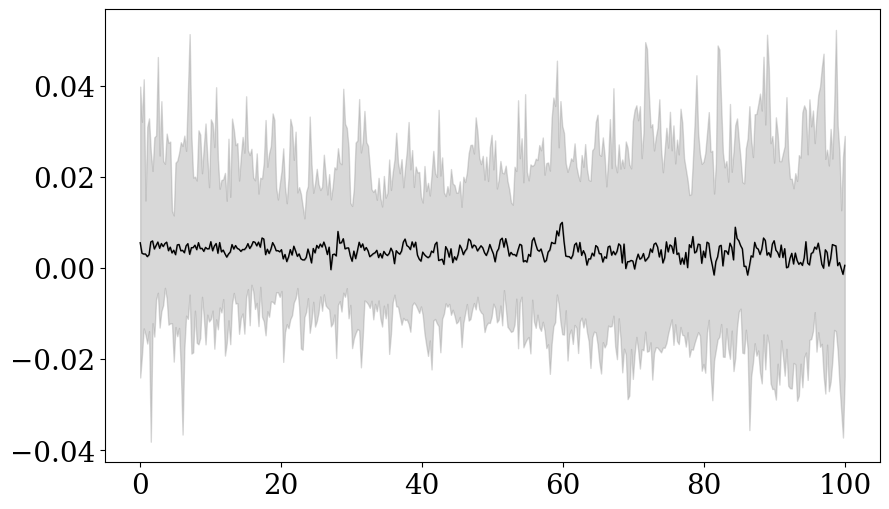

In [63]:
# real GDP growth
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['real_gdp_growth'], color='k', linewidth=1)
plt.fill_between(years, data_median['real_gdp_growth'], data_upper['real_gdp_growth'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['real_gdp_growth'], data_lower['real_gdp_growth'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\rdgpg_{suffix}.png', bbox_inches='tight')
plt.show()

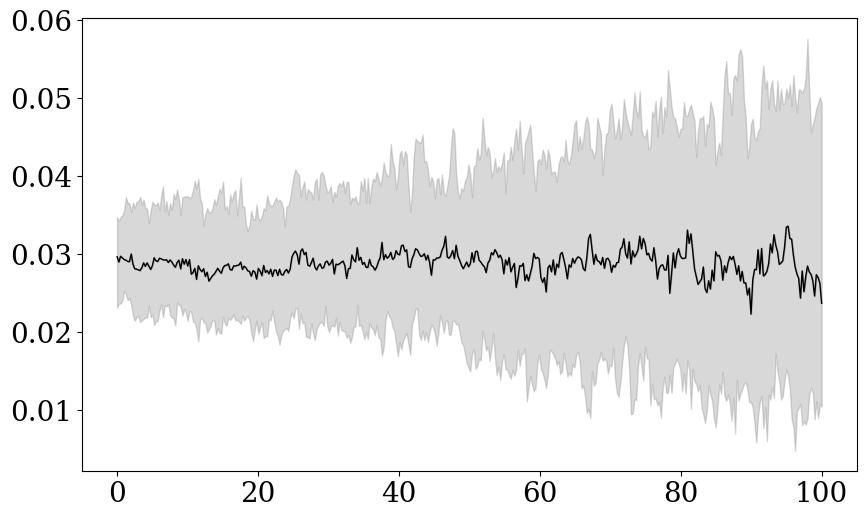

In [64]:
# inflation
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['inflation'], color='k', linewidth=1)
plt.fill_between(years, data_median['inflation'], data_upper['inflation'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['inflation'], data_lower['inflation'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\inflation_{suffix}.png', bbox_inches='tight')
plt.show()

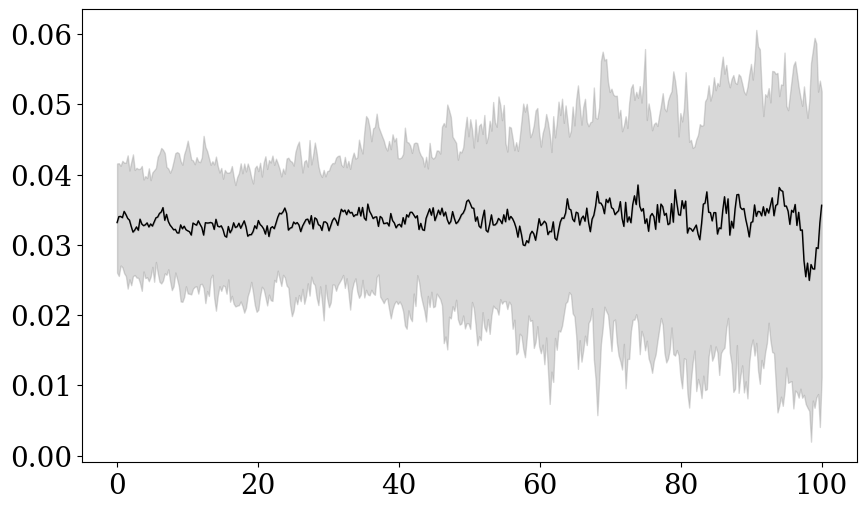

In [65]:
# wage inflation
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['wage_inflation'], color='k', linewidth=1)
plt.fill_between(years, data_median['wage_inflation'], data_upper['wage_inflation'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['wage_inflation'], data_lower['wage_inflation'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\wage_inflation_{suffix}.png', bbox_inches='tight')
plt.show()

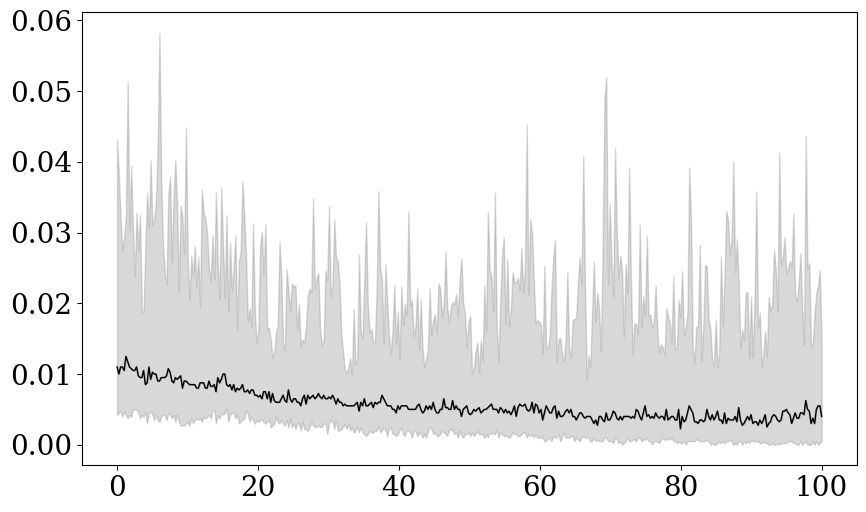

In [66]:
# unemployment
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['unemployment_rate'], color='k', linewidth=1)
plt.fill_between(years, data_median['unemployment_rate'], data_upper['unemployment_rate'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['unemployment_rate'], data_lower['unemployment_rate'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\unemployment_{suffix}.png', bbox_inches='tight')
plt.show()

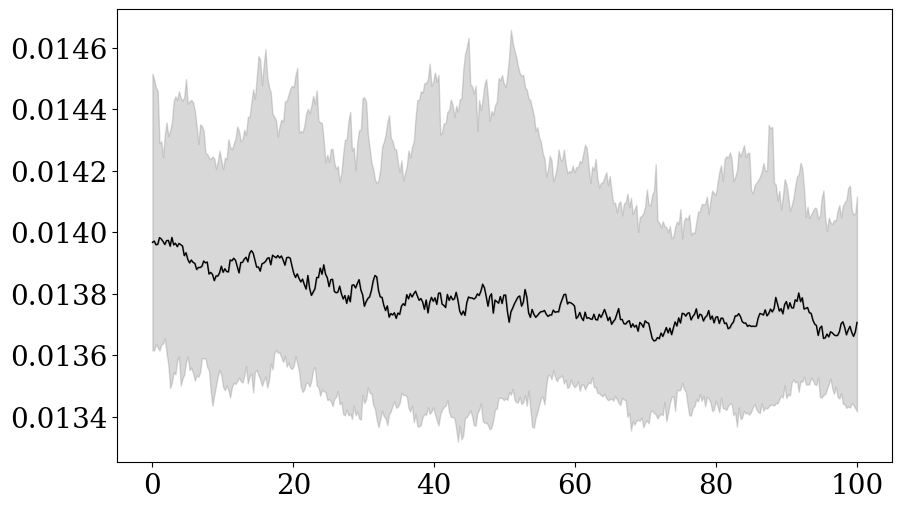

In [67]:
# loan interest
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['avg_loan_interest'], color='k', linewidth=1)
plt.fill_between(years, data_median['avg_loan_interest'], data_upper['avg_loan_interest'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['avg_loan_interest'], data_lower['avg_loan_interest'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\interest_{suffix}.png', bbox_inches='tight')
plt.show()

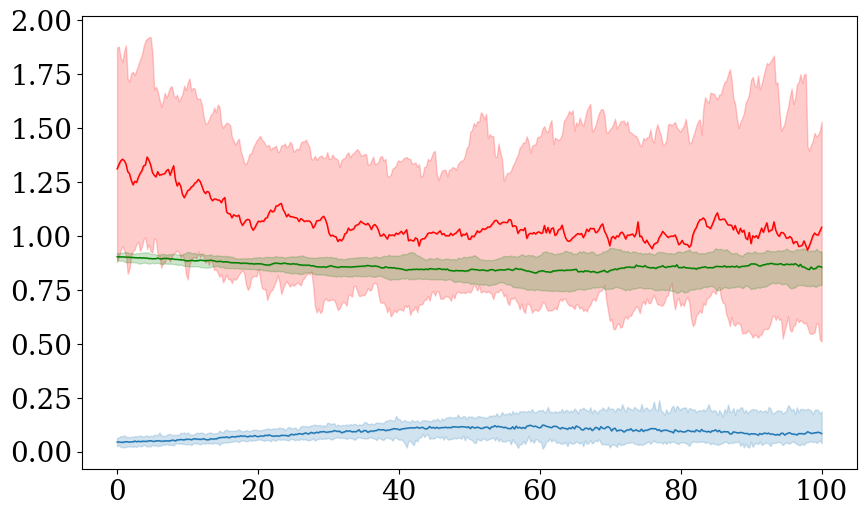

In [68]:
# debt ratio
plt.figure(figsize=(x_figsize,y_figsize))
# debt ratio
plt.plot(years, data_median['debt_ratio'], color='r', linewidth=1)
plt.fill_between(years, data_median['debt_ratio'], data_upper['debt_ratio'], color='r', alpha=0.2)
plt.fill_between(years, data_median['debt_ratio'], data_lower['debt_ratio'], color='r', alpha=0.2)
# wage share 
plt.plot(years, data_median['wage_share'], color='g', linewidth=1)
plt.fill_between(years, data_median['wage_share'], data_upper['wage_share'], color='g', alpha=0.2)
plt.fill_between(years, data_median['wage_share'], data_lower['wage_share'], color='g', alpha=0.2)
# profit share
plt.plot(years, data_median['profit_share'], color='tab:blue', linewidth=1)
plt.fill_between(years, data_median['profit_share'], data_upper['profit_share'], color='tab:blue', alpha=0.2)
plt.fill_between(years, data_median['profit_share'], data_lower['profit_share'], color='tab:blue', alpha=0.2)
# ticks
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\output_shares_{suffix}.png', bbox_inches='tight')
plt.show()

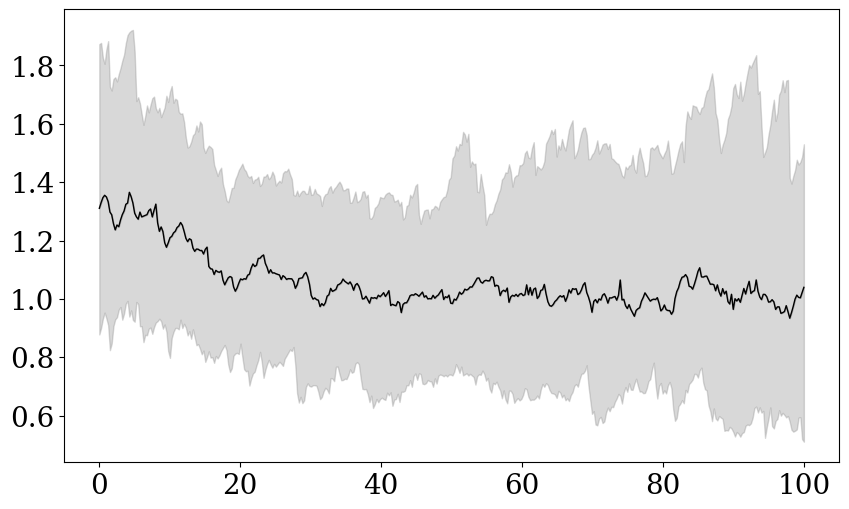

In [69]:
# debt ratio
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['debt_ratio'], color='k', linewidth=1)
plt.fill_between(years, data_median['debt_ratio'], data_upper['debt_ratio'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['debt_ratio'], data_lower['debt_ratio'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\debt_ratio_{suffix}.png', bbox_inches='tight')
plt.show()

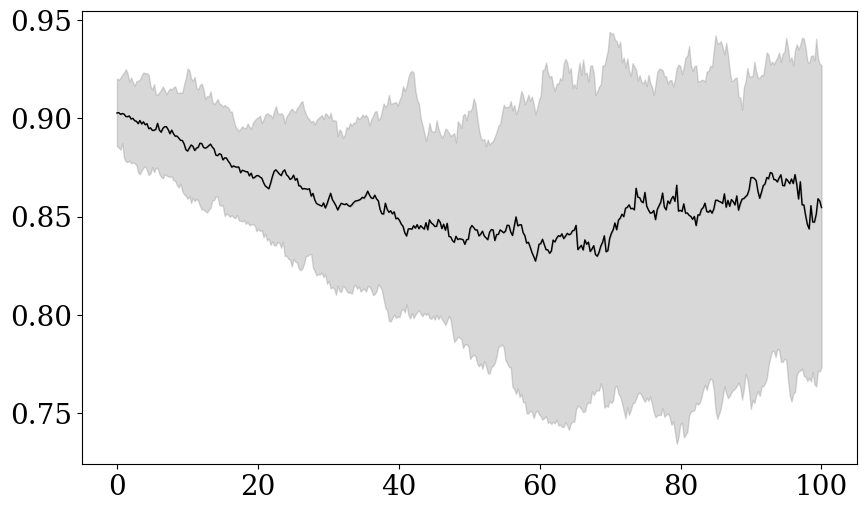

In [70]:
# wage share
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['wage_share'], color='k', linewidth=1)
plt.fill_between(years, data_median['wage_share'], data_upper['wage_share'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['wage_share'], data_lower['wage_share'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\wage_share_{suffix}.png', bbox_inches='tight')
plt.show()

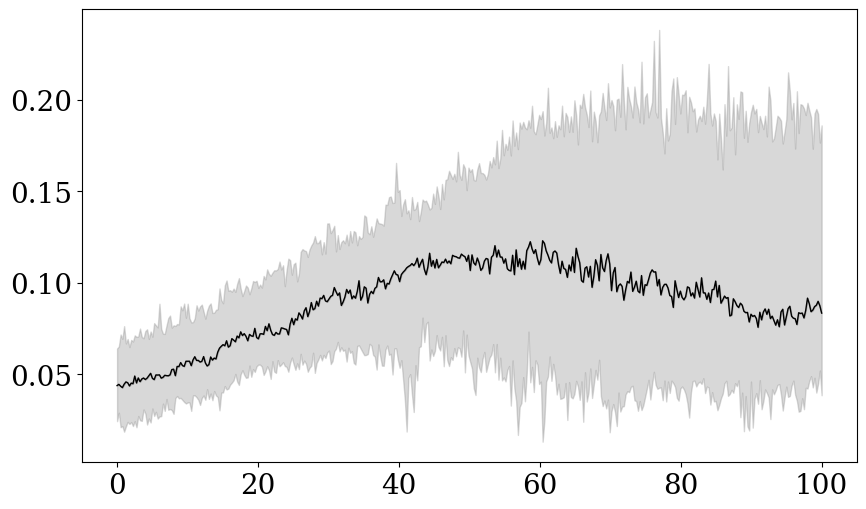

In [71]:
# profit share
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['profit_share'], color='k', linewidth=1)
plt.fill_between(years, data_median['profit_share'], data_upper['profit_share'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['profit_share'], data_lower['profit_share'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\profit_share_{suffix}.png', bbox_inches='tight')
plt.show()

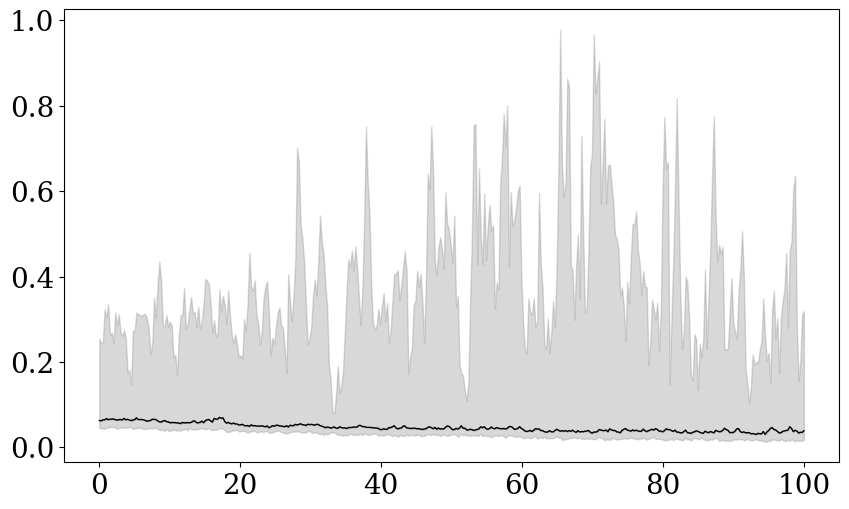

In [72]:
# cfirm hpi
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['cfirm_hpi'], color='k', linewidth=1)
plt.fill_between(years, data_median['cfirm_hpi'], data_upper['cfirm_hpi'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['cfirm_hpi'], data_lower['cfirm_hpi'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\cfirm_hpi_{suffix}.png', bbox_inches='tight')
plt.show()

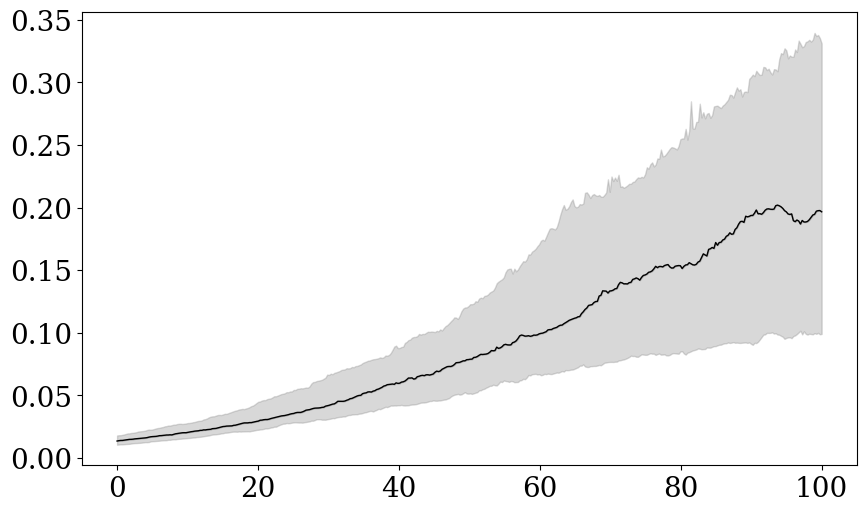

In [73]:
# cfirm normalised hhi
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['cfirm_nhhi'], color='k', linewidth=1)
plt.fill_between(years, data_median['cfirm_nhhi'], data_upper['cfirm_nhhi'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['cfirm_nhhi'], data_lower['cfirm_nhhi'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\cfirm_nhhi_{suffix}.png', bbox_inches='tight')
plt.show()

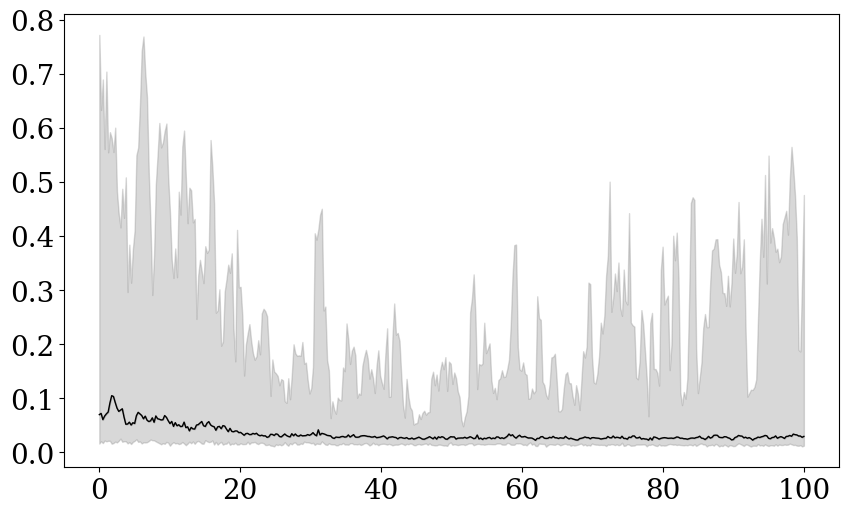

In [74]:
# kfirm hpi
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['kfirm_hpi'], color='k', linewidth=1)
plt.fill_between(years, data_median['kfirm_hpi'], data_upper['kfirm_hpi'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['kfirm_hpi'], data_lower['kfirm_hpi'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\kfirm_hpi_{suffix}.png', bbox_inches='tight')
plt.show()

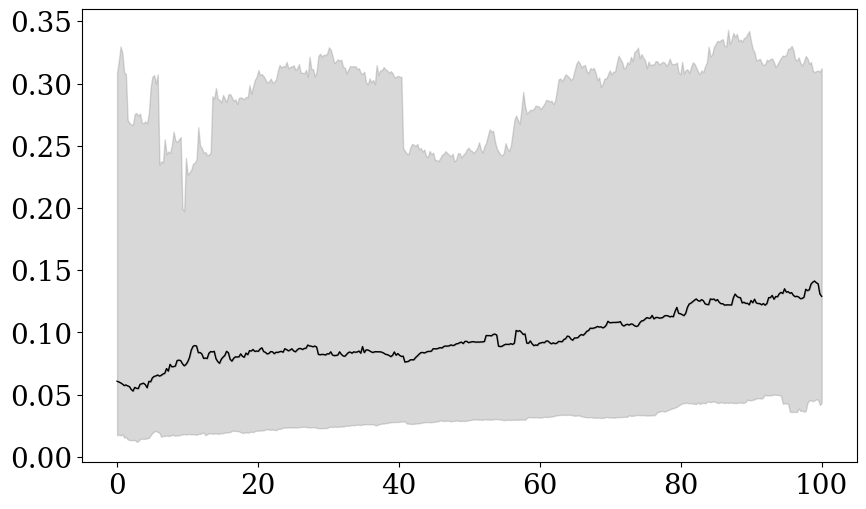

In [75]:
# kfirm normalised hhi
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['kfirm_nhhi'], color='k', linewidth=1)
plt.fill_between(years, data_median['kfirm_nhhi'], data_upper['kfirm_nhhi'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['kfirm_nhhi'], data_lower['kfirm_nhhi'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\kfirm_nhhi_{suffix}.png', bbox_inches='tight')
plt.show()

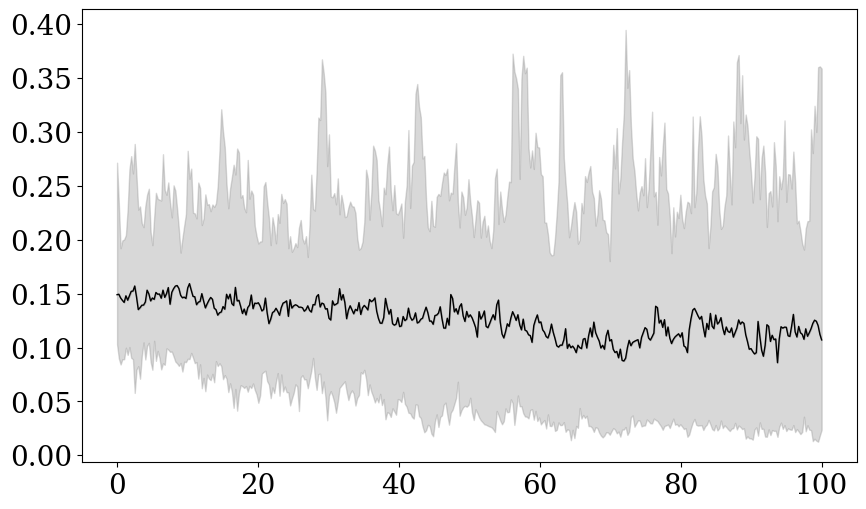

In [76]:
# bank hpi
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['bank_hpi'], color='k', linewidth=1)
plt.fill_between(years, data_median['bank_hpi'], data_upper['bank_hpi'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['bank_hpi'], data_lower['bank_hpi'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\bank_hpi_{suffix}.png', bbox_inches='tight')
plt.show()

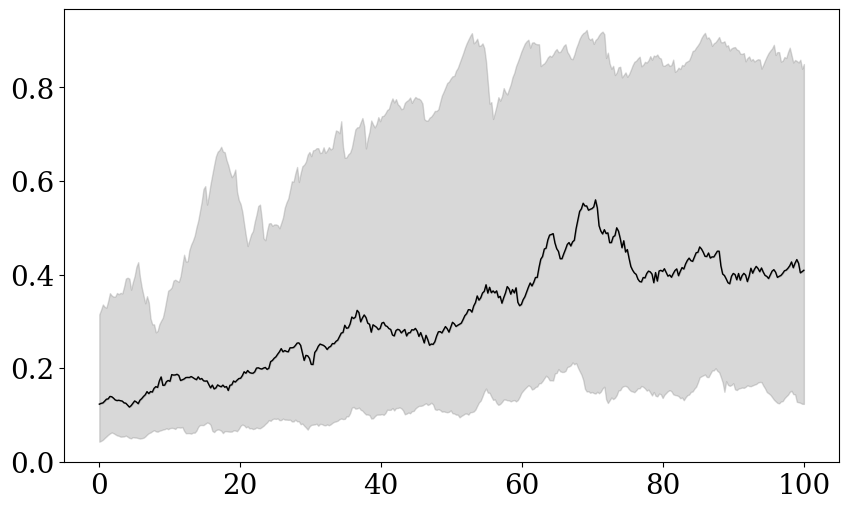

In [77]:
# bank normalised hhi
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['bank_nhhi'], color='k', linewidth=1)
plt.fill_between(years, data_median['bank_nhhi'], data_upper['bank_nhhi'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['bank_nhhi'], data_lower['bank_nhhi'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\bank_nhhi_{suffix}.png', bbox_inches='tight')
plt.show()

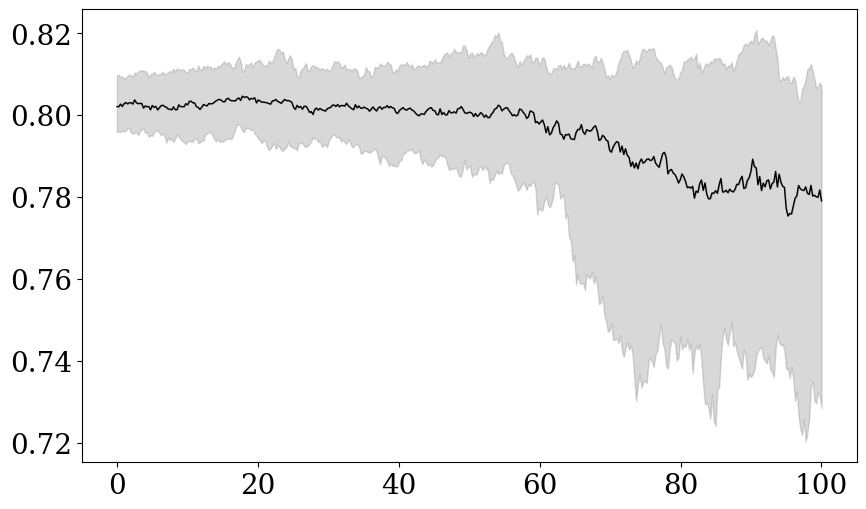

In [78]:
# gini
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['gini'], color='k', linewidth=1)
plt.fill_between(years, data_median['gini'], data_upper['gini'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['gini'], data_lower['gini'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\gini_{suffix}.png', bbox_inches='tight')
plt.show()

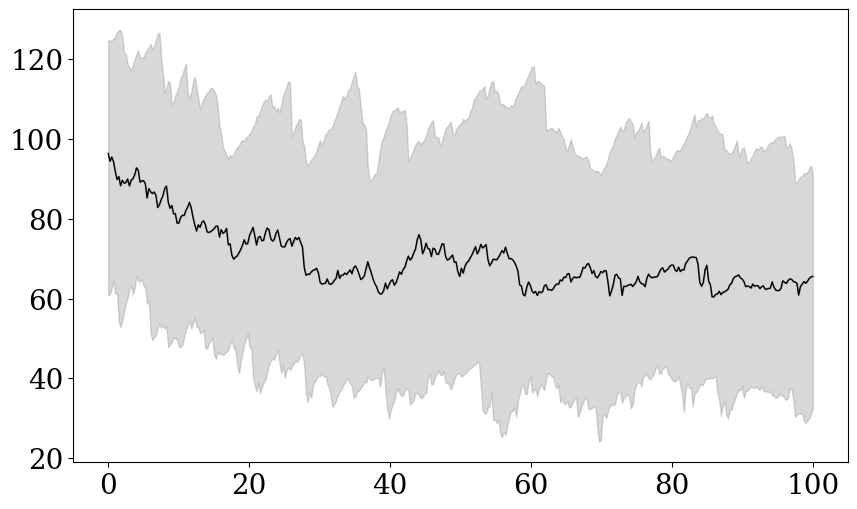

In [79]:
# bank mean degree
plt.figure(figsize=(x_figsize,y_figsize))
plt.plot(years, data_median['bank_mean_degree'], color='k', linewidth=1)
plt.fill_between(years, data_median['bank_mean_degree'], data_upper['bank_mean_degree'], color='grey', alpha=0.3)
plt.fill_between(years, data_median['bank_mean_degree'], data_lower['bank_mean_degree'], color='grey', alpha=0.3)
plt.yticks(fontsize=large)
plt.xticks(fontsize=large)
plt.savefig(f'{figure_path}\\bank_mean_degree_{suffix}.png', bbox_inches='tight')
plt.show()

## Statistical Analysis

### Average Values of the Mean Across Simulations

In [80]:
# group by simulation
sim_group = data.groupby(by=['simulation'])

In [81]:
# average of mean values across simulations
averages = sim_group.mean().mean()
# save as csv
averages.to_csv(f'{analysis_path}\\simulated\\tables\\averages_{suffix}.csv')
averages

time                        400.500000
consumption                2816.546261
nominal_consumption       74252.661215
investment                  356.970647
nominal_investment         9909.621571
real_gdp                   3173.516907
nominal_gdp               84162.282786
capital                   21516.224199
cfirm_productivity            1.665147
kfirm_productivity            1.844480
debt                      87803.947132
profits                    8534.092391
cfirm_price_index            24.361150
kfirm_price_index            23.601767
cfirm_nhhi                    0.094764
kfirm_nhhi                    0.120790
cfirm_hpi                     0.100150
kfirm_hpi                     0.071225
cfirm_bankruptcy              2.557100
kfirm_bankruptcy              0.400100
wages                     71724.719801
avg_wage                     36.113963
employment                 1983.826450
unemployment_rate             0.008087
vacancy_ratio                 8.436618
gini                     

In [82]:
# averages standard errors
averages_se = sim_group.mean().sem()
# save as csv
averages_se.to_csv(f'{analysis_path}\\simulated\\tables\\averages_se_{suffix}.csv')
averages_se

time                         0.000000
consumption                 22.626351
nominal_consumption       1749.858757
investment                   6.761468
nominal_investment         478.690763
real_gdp                    26.822878
nominal_gdp               1991.759461
capital                    539.447896
cfirm_productivity           0.010507
kfirm_productivity           0.029719
debt                      2185.957000
profits                    441.467943
cfirm_price_index            0.561959
kfirm_price_index            0.699169
cfirm_nhhi                   0.003715
kfirm_nhhi                   0.011367
cfirm_hpi                    0.001473
kfirm_hpi                    0.001820
cfirm_bankruptcy             0.051162
kfirm_bankruptcy             0.010487
wages                     1816.827840
avg_wage                     0.908938
employment                   0.265116
unemployment_rate            0.000133
vacancy_ratio                0.433283
gini                         0.000941
bank_nhhi   

### Average Values of Standard Deviation Across Simulations

In [83]:
# average of standard deviations across simulations
std = sim_group.std().mean()
# save as csv
std.to_csv(f'{analysis_path}\\simulated\\tables\\standard_deviations_{suffix}.csv')
std

time                        115.614301
consumption                 336.213439
nominal_consumption       66921.275477
investment                   96.352471
nominal_investment         9246.208431
real_gdp                    411.510311
nominal_gdp               75448.004391
capital                    7428.208929
cfirm_productivity            0.291401
kfirm_productivity            0.255157
debt                      82334.186903
profits                    8512.693545
cfirm_price_index            19.726159
kfirm_price_index            18.000095
cfirm_nhhi                    0.062829
kfirm_nhhi                    0.042929
cfirm_hpi                     0.161494
kfirm_hpi                     0.122852
cfirm_bankruptcy              7.517462
kfirm_bankruptcy              1.507359
wages                     64561.896019
avg_wage                     32.488026
employment                   18.430129
unemployment_rate             0.009215
vacancy_ratio                 3.788577
gini                     

In [85]:
# standard errors
std_se = sim_group.std().sem()
# save as csv
std_se.to_csv(f'{analysis_path}\\simulated\\tables\\standard_deviations_se_{suffix}.csv')
std_se

time                     2.030122e-15
consumption              1.556564e+01
nominal_consumption      2.332994e+03
investment               6.647472e+00
nominal_investment       6.456524e+02
real_gdp                 1.874809e+01
nominal_gdp              2.636478e+03
capital                  4.519781e+02
cfirm_productivity       7.389999e-03
kfirm_productivity       1.340003e-02
debt                     3.659939e+03
profits                  5.900622e+02
cfirm_price_index        7.355124e-01
kfirm_price_index        9.029010e-01
cfirm_nhhi               3.387769e-03
kfirm_nhhi               3.816926e-03
cfirm_hpi                6.551904e-03
kfirm_hpi                5.593724e-03
cfirm_bankruptcy         1.532372e-01
kfirm_bankruptcy         3.500128e-02
wages                    2.382392e+03
avg_wage                 1.191082e+00
employment               6.210566e-01
unemployment_rate        3.105283e-04
vacancy_ratio            4.763429e-01
gini                     9.999391e-04
bank_nhhi   